# NLP - Text classification - Creating Word2Vec embeddings

We have seen text classification using TF-IDF vectors in a prior notebook. We will be focusing on Wor2Vec embeddings now.

<p> 

 ***Context*** : Language / Text consists of many unique words, some of them are similar and some of them are related and some opposite of one another. For any Machine learning application we can't use the text directly, so we need to convert words into numbers / vectors. At the same time we want to preserve the information of relationship among the words. This requires us to do 2 things
 1. Represent words / tokens with one or more numerical values.
 2. Define relations among the numerical representation of words
 </p>

We call this representation as Embeddings in NLP.

**What are embeddings ?** Embeddings are relatively low dimensional representation of high dimensional data. Of course  , representing in low dimensional is not enough to get meaningful use out of embeddings, they have to capture some of the niceties of the data we are representing. In NLP its called semantic meaning. 


 
. 



## Imports

In [45]:
import warnings
warnings.filterwarnings("ignore") # Just to keep notebook clean. You should see why warnings are coming up & resolve them if possible & necessary.

import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data import Dataset
import tensorflow.data as tf_data
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
tf.config.list_physical_devices('GPU') # Checking if GPU is available. Good to have but not necessary for the current task

2023-10-28 21:13:19.282438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 21:13:19.288067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 21:13:19.288382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading data

In [4]:
train_df = pd.read_csv('../data/nlp-getting-started/train.csv')

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


- Lets see all the unique characters in the data

In [7]:
all_chars = dict()
for text in train_df['text'].values:
    for character in text.lower().replace(' ',''):
        if not character in all_chars:
            all_chars[character] = 1
            continue
        else:
            all_chars[character] += 1

In [8]:
print(dict(sorted(all_chars.items(), key=lambda item: item[1], reverse=True)))

{'e': 59118, 't': 56349, 'a': 46642, 'o': 45484, 'i': 40694, 'n': 36952, 's': 36306, 'r': 34903, 'h': 26936, 'l': 25487, 'c': 22504, 'd': 21922, 'u': 17381, 'p': 17128, 'm': 16995, '/': 14585, 'g': 13651, 'f': 12663, 'y': 12309, 'w': 11752, '.': 11696, 'b': 11530, 'k': 7895, 'v': 7302, ':': 6910, '#': 3403, 'j': 3222, "'": 3157, '?': 3126, 'x': 2790, '@': 2759, '0': 2456, 'z': 2446, '1': 2252, 'q': 1974, '-': 1753, '2': 1706, '3': 1520, '5': 1517, '4': 1311, '7': 1238, '9': 1234, '!': 1173, '6': 1166, '8': 1133, '\n': 946, '_': 863, '\x89': 797, 'û': 794, ';': 587, '&': 457, ')': 373, '(': 349, 'ª': 191, '*': 179, '|': 152, '[': 132, ']': 131, 'å': 96, '+': 80, 'ï': 69, 'ê': 66, '=': 53, '÷': 49, '%': 46, 'ò': 45, '$': 44, '\x9d': 44, '~': 37, 'ó': 33, 'ì': 27, '¢': 10, '©': 10, '£': 6, '^': 6, '¨': 6, 'è': 5, '\\': 5, '¼': 5, '}': 4, 'ñ': 3, '¤': 3, '¡': 3, '`': 3, '{': 3, ',': 2, 'ã': 2, 'ü': 2, 'ç': 2, 'â': 2, '«': 2, '>': 1, '´': 1, '¬': 1}


- We can see that many non alphanumeric characters are present. We will remove all non alphanumeric characters except #

In [9]:
def clean_text(text):
    """
        Removes Non alpha numeric characters except # and space. Also lower cases the text.
        Params:
            text : Input text
        Returns: Cleaned & formatted text
    """
    return re.sub('[^a-z0-9\s#]',' ',text.lower()).replace('\s+',' ').strip()

In [10]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [11]:
train_df['cleaned_text'].apply(len).describe()

count    7613.00000
mean      100.20754
std        33.95609
min         6.00000
25%        77.00000
50%       106.00000
75%       132.00000
max       151.00000
Name: cleaned_text, dtype: float64

- Encoding the text data using TextVectorization layer, which will identify most frequent words & limit our vocabulary to a specified number of tokens.
- It also provides a plugin way to clean the data as required. Here in tweets we want to keep # so we are not using the default text standardizer.

In [12]:
def standardize(input_data):
  lower_cased = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lower_cased,'[^a-z0-9#\s]', '')

- To train under Tensorflow, we need to convert our data from Pandas column to Tensorflow dataset.

In [13]:
# Representing each value of our text string as Tensorflow constant of String type & creating a list of tensors.
text_dataset = Dataset.from_tensor_slices([tf.constant(text, dtype=tf.string) for text in train_df['text'].values])


2023-10-28 21:22:10.612308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 21:22:10.612764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-28 21:22:10.613116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
vocab_size = 5000 # Keeping our vocab size to 5k
sequence_length = 160 # As max size of tweet is 160, we limit our sequence length to it

encoding_layer = layers.TextVectorization(
                                            standardize=standardize,
                                            max_tokens=vocab_size,
                                            output_mode='int',
                                            output_sequence_length=sequence_length
                                        )

Adapting the layer with our data

In [15]:
encoding_layer.adapt(text_dataset.batch(1024))

**As we want to use the encoding layer later on will be saving it to disk**

In [18]:
with open('../data/nlp-getting-started/text_vectorizer.pckl','wb+') as file:
    pickle.dump({
                'config': encoding_layer.get_config(),
                'weights': encoding_layer.get_weights()
                }
                , file)

In [19]:
inverse_vocab = encoding_layer.get_vocabulary()
print(inverse_vocab[:30])

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for', 'on', 'you', 'my', 'with', 'it', 'that', 'at', 'by', 'this', 'from', 'be', 'are', 'have', 'was', 'like', 'as', 'me', 'up', 'just']


You can see [UNK] token for representing any unknown words. As we are limiting ou Vocab size to 5K top frequent words, <br> we will have many unknown words which occur rarely.

In [20]:
text_encoded_vectors = list(text_dataset.batch(1024).map(encoding_layer).unbatch().as_numpy_iterator())

In [21]:
" ".join([inverse_vocab[token] for token in text_encoded_vectors[2] if token != 0])

'all residents asked to shelter in place are being [UNK] by officers no other evacuation or shelter in place orders are expected'

In [22]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [23]:
targets, contexts, labels = generate_training_data(
    sequences=text_encoded_vectors,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 7613/7613 [00:43<00:00, 173.38it/s]




targets.shape: (56811,)
contexts.shape: (56811, 5)
labels.shape: (56811, 5)


In [24]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [25]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [26]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=5)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [28]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [30]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20


2023-10-28 21:34:36.396386: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7d9ada0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 21:34:36.396410: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-10-28 21:34:36.409143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-28 21:34:36.437343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-28 21:34:36.576218: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 [==============================] - 5s 81ms/step - loss: 1.6076 - accuracy: 0.2616
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 1.5819 - accuracy: 0.6621
Epoch 3/20
55/55 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.7222
Epoch 4/20
55/55 [==============================] - 0s 2ms/step - loss: 1.4288 - accuracy: 0.7110
Epoch 5/20
55/55 [==============================] - 0s 2ms/step - loss: 1.3359 - accuracy: 0.7114
Epoch 6/20
55/55 [==============================] - 0s 2ms/step - loss: 1.2420 - accuracy: 0.7295
Epoch 7/20
55/55 [==============================] - 0s 2ms/step - loss: 1.1442 - accuracy: 0.7540
Epoch 8/20
55/55 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 0.7776
Epoch 9/20
55/55 [==============================] - 0s 2ms/step - loss: 0.9532 - accuracy: 0.7991
Epoch 10/20
55/55 [==============================] - 0s 2ms/step - loss: 0.8660 - accuracy: 0.8195
Epoch 11/20
55/55 [==========

In [48]:
#docs_infra: no_execute
%tensorboard --logdir logs

In [32]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = encoding_layer.get_vocabulary()

In [38]:
word2vec.save('../data/nlp-getting-started/word2vec_model')

INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff2603adf60>, 140677629492752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff2603adf60>, 140677629492752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff260216c80>, 140677629790608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff260216c80>, 140677629790608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff2603adf60>, 140677629492752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff2603adf60>, 140677629492752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff260216c80>, 140677629790608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 128]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff260216c80>, 140677629790608), {}).


INFO:tensorflow:Assets written to: ../data/nlp-getting-started/word2vec_model/assets


INFO:tensorflow:Assets written to: ../data/nlp-getting-started/word2vec_model/assets


## How good are our embeddings?
Usually the best way to check performance of embeddings is to use them in down stream tasks like, classification, summarization, Q & A etc. <br>
But we can see qualitatively using TSNE plots & retrieving learnt similar words 


In [34]:
embeedings = word2vec.get_layer('w2v_embedding').get_weights()[0]

In [42]:
transformed_word_vecs = TSNE(n_components=2, learning_rate='auto',
...                   init='random', perplexity=3).fit_transform(embeedings)

(5000, 2)

In [39]:
encoding_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'have',
 'was',
 'like',
 'as',
 'me',
 'up',
 'just',
 'so',
 'but',
 'im',
 'amp',
 'not',
 'your',
 'its',
 'out',
 'all',
 'after',
 'will',
 'when',
 'no',
 'an',
 'has',
 'fire',
 'if',
 'we',
 'get',
 'new',
 'now',
 'via',
 'more',
 'about',
 'dont',
 'or',
 'what',
 'people',
 'one',
 'he',
 'they',
 'how',
 'been',
 'over',
 'who',
 'into',
 'do',
 'were',
 'video',
 'can',
 '2',
 'us',
 'emergency',
 'there',
 'disaster',
 'police',
 'than',
 'her',
 'would',
 'still',
 'some',
 'his',
 'body',
 'news',
 'burning',
 'back',
 'crash',
 'suicide',
 'storm',
 'why',
 'time',
 'them',
 'off',
 'know',
 'got',
 'california',
 'had',
 'buildings',
 'man',
 'first',
 'day',
 'cant',
 'see',
 'going',
 'bomb',
 'our',
 'fires',
 'attack',
 'rt',
 'two',
 'love',
 '3',
 'youtube',
 'go',
 'dead',
 'killed',
 'the

In [63]:
x = [vec[0] for vec in transformed_word_vecs][1000:1500]
y = [vec[1] for vec in transformed_word_vecs][1000:1500]

In [49]:
vocab_encoding_layer = encoding_layer.get_vocabulary()

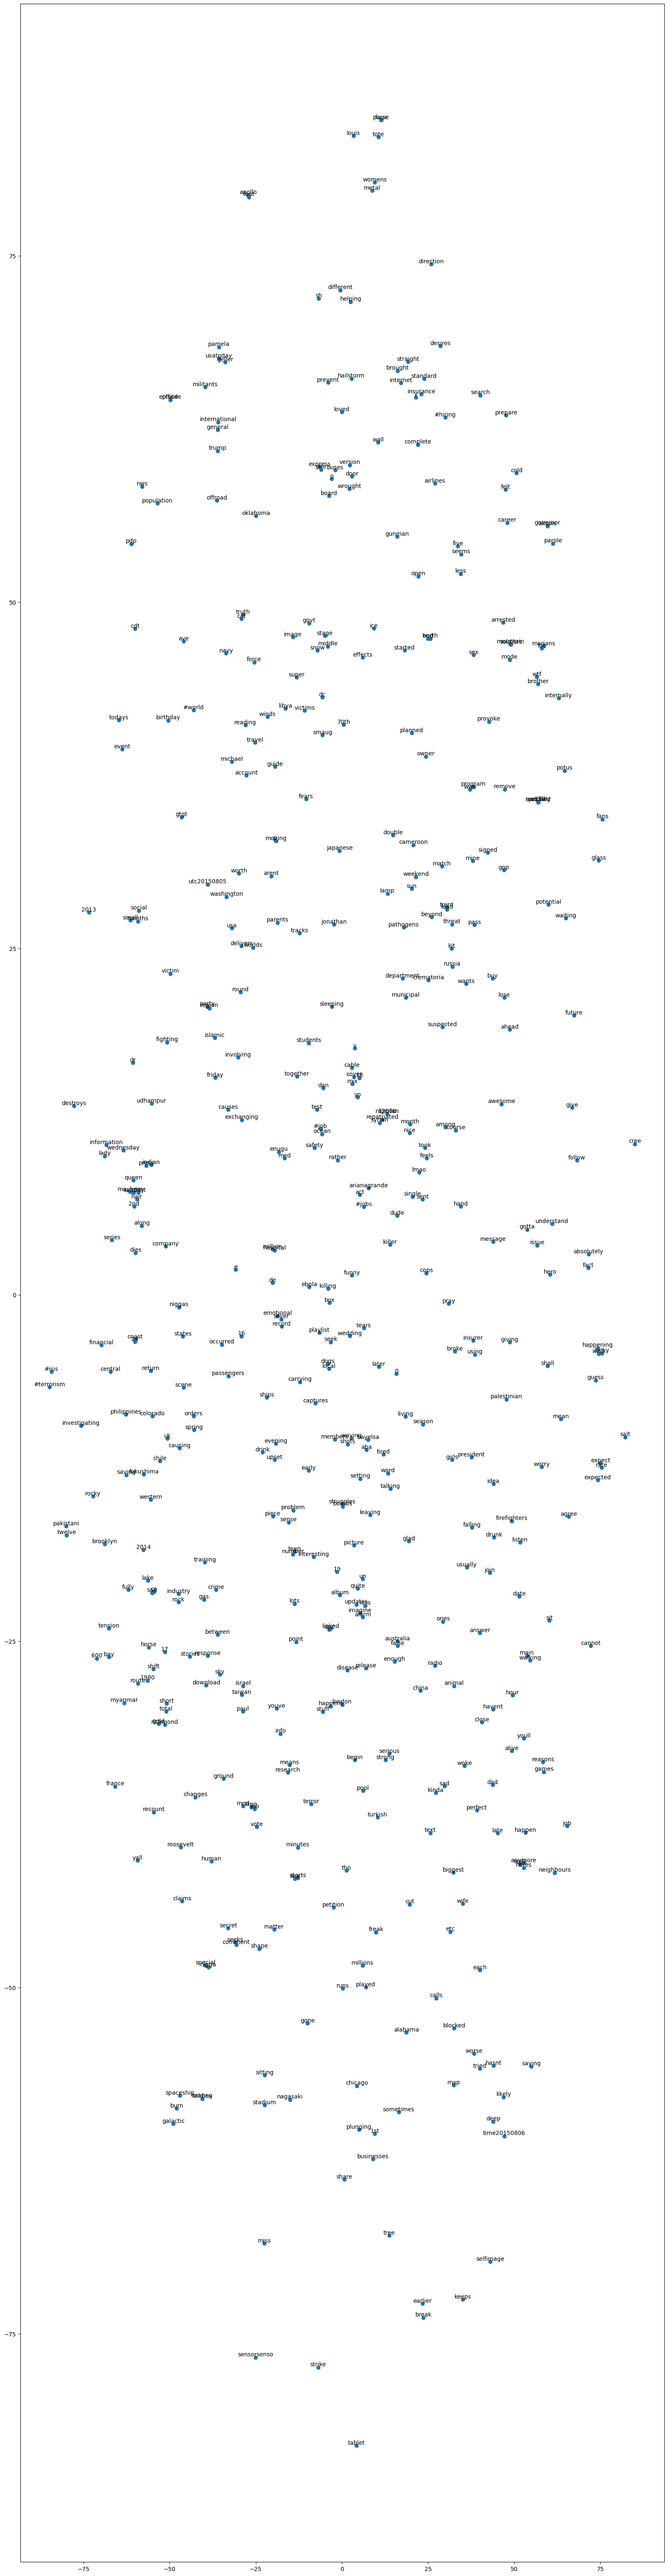

In [64]:


# plot x and y on scatter plot
plt.figure(figsize=(20,80))
plt.scatter(x, y)

# add labels to all points
for (xi, yi, word) in zip(x, y, vocab_encoding_layer[1000:1500]):
    plt.annotate(f"{word}", (xi, yi), va='bottom', ha='center')

# show the plot
plt.show()


You can see clusters of data points which are closer in the embedding space. 
Sample cluster - spaceship, burn, galactic ; secret, seek , comment, shape;  

**Next notebook we will see how to use these embeddings to enhance our text classification performance.**

## References

Word2vec implementation is taken from Google colab notebook @ <a href="https://www.tensorflow.org/text/tutorials/word2vec">Google Colab Notebook</a>